<a href="https://colab.research.google.com/github/emitejadaa/NeuroLinked/blob/main/notebooks/EEG_motor_imaginery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install -q --no-cache-dir mne lightning torchmetrics

In [29]:
import mne
from mne.io import concatenate_raws

import os
import re
import io
import cv2
import random
import string
import warnings
import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.classification import Accuracy

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
path="/content/drive/MyDrive/Colab-Datset/eegmmidb/"

In [27]:
import warnings
import re
import numpy as np
import mne
from mne.io import concatenate_raws
from pathlib import Path

warnings.filterwarnings("ignore")


N_SUBJECT = 109
BASELINE_EYE_OPEN = [1]
BASELINE_EYE_CLOSED = [2]
OPEN_CLOSE_LEFT_RIGHT_FIST = [3, 7, 11]
IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]
OPEN_CLOSE_BOTH_FIST = [5, 9, 13]
IMAGINE_OPEN_CLOSE_BOTH_FIST = [6, 10, 14]

DATA_ROOT = Path("/content/drive/MyDrive/Colab-Dataset/eegmidb/MNE-eegbci-data/files")


edf_files = list(DATA_ROOT.rglob("*.edf"))
pat = re.compile(r"[Ss](\d{3})[Rr](\d{2})\.edf$")

physionet_paths = []
for p in edf_files:
    m = pat.search(p.name)
    if not m:
        continue
    subj = int(m.group(1))
    run = int(m.group(2))
    if 1 <= subj <= (N_SUBJECT - 30) and run in IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST:
        physionet_paths.append(p)

physionet_paths = sorted(
    physionet_paths,
    key=lambda p: (int(p.name[1:4]), int(p.name[5:7]))
)

if not physionet_paths:
    raise FileNotFoundError(
        f"No se encontraron archivos EDF en {DATA_ROOT}. Comprueba la ruta y la estructura de carpetas."
    )

parts = [
    mne.io.read_raw_edf(
        str(path),
        preload=True,
        stim_channel='auto',
        verbose='WARNING',
    )
    for path in physionet_paths
]

raw = concatenate_raws(parts)
sample_raw_data = raw.get_data()[0, :500]

events, _ = mne.events_from_annotations(raw)

eeg_channel_inds = mne.pick_types(
    raw.info,
    meg=False,
    eeg=True,
    stim=False,
    eog=False,
    exclude='bads',
)
EEG_CHANNEL = int(len(eeg_channel_inds))

epoched = mne.Epochs(
    raw,
    events,
    dict(left=2, right=3),
    tmin=1,
    tmax=4.1,
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
)

X = (epoched.get_data() * 1e3).astype(np.float32)

y = (epoched.events[:, 2] - 2).astype(np.int64)

CLASSES = ["left", "right"]


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
3555 matching events found
No baseline correction applied
Using data from preloaded Raw for 3555 events and 497 original time points ...
178 bad epochs dropped


In [32]:
class EEGDataset(data.Dataset):
    def __init__(self, x, y=None, inference=False):
        super().__init__()

        N_SAMPLE = x.shape[0]
        val_idx = int(0.9 * N_SAMPLE)
        train_idx = int(0.81 * N_SAMPLE)

        if not inference:
            self.train_ds = {
                'x': x[:train_idx],
                'y': y[:train_idx],
            }
            self.val_ds = {
                'x': x[train_idx:val_idx],
                'y': y[train_idx:val_idx],
            }
            self.test_ds = {
                'x': x[val_idx:],
                'y': y[val_idx:],
            }
        else:
            self.__split = "inference"
            self.inference_ds = {
                'x': [x],
            }

    def __len__(self):
        return len(self.dataset['x'])

    def __getitem__(self, idx):

        x = self.dataset['x'][idx]
        if self.__split != "inference":
            y = self.dataset['y'][idx]
            x = torch.tensor(x).float()
            y = torch.tensor(y).unsqueeze(-1).float()
            return x, y
        else:
            x = torch.tensor(x).float()
            return x

    def split(self, __split):
        self.__split = __split
        return self

    @classmethod
    def inference_dataset(cls, x):
        return cls(x, inference=True)

    @property
    def dataset(self):
        assert self.__split is not None, "Please specify the split of dataset!"

        if self.__split == "train":
            return self.train_ds
        elif self.__split == "val":
            return self.val_ds
        elif self.__split == "test":
            return self.test_ds
        elif self.__split == "inference":
            return self.inference_ds
        else:
            raise TypeError("Unknown type of split!")

In [33]:
eeg_dataset = EEGDataset(x=X, y=y)

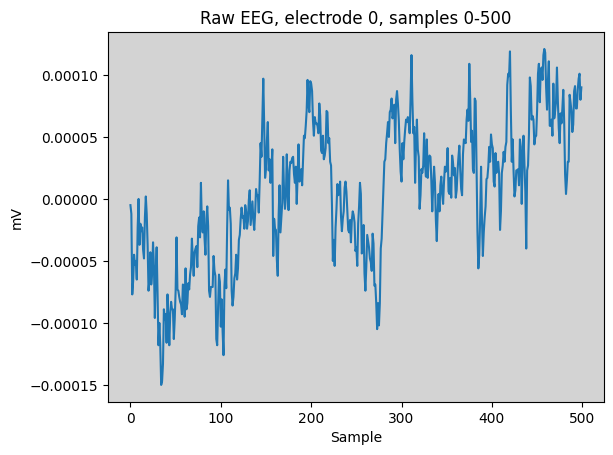

<Figure size 640x480 with 0 Axes>

In [34]:
plt.plot(sample_raw_data)
plt.title("Raw EEG, electrode 0, samples 0-500")
plt.ylabel("mV")
plt.xlabel("Sample")
plt.show()
plt.clf()

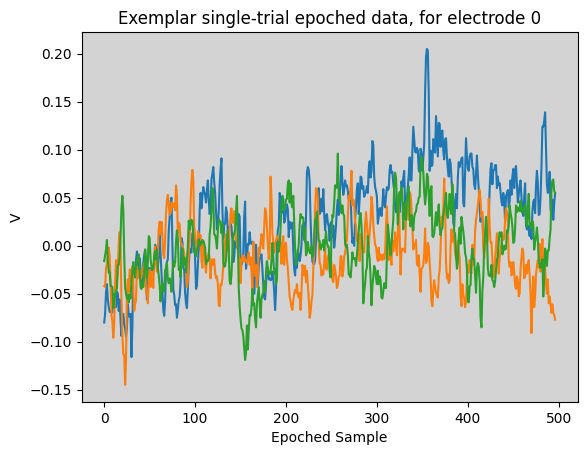

<Figure size 640x480 with 0 Axes>

In [35]:
plt.plot(X[18:21, 0, :].T)
plt.title("Exemplar single-trial epoched data, for electrode 0")
plt.ylabel("V")
plt.xlabel("Epoched Sample")
plt.show()
plt.clf()

In [36]:
del raw, events, epoched, physionet_paths, eeg_channel_inds, parts

In [37]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out

In [38]:
class ModelWrapper(L.LightningModule):
    def __init__(self, arch, dataset, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.dataset = dataset
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        acc = self.val_accuracy.compute().data.cpu()

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.test_accuracy.update(y_hat, y)

        self.log(
            "test_loss",
            loss,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):

        # Loss
        loss_img_file = "/content/loss_plot.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = "/content/acc_plot.png"
        plt.plot(self.train_acc, color = 'r', label='train')
        plt.plot(self.val_acc, color = 'b', label='validation')
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("train"),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("val"),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("test"),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):

        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.25),
                    int(self.max_epoch * 0.5),
                    int(self.max_epoch * 0.75),
                ],
                gamma=0.1
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

In [39]:
class PositionalEncoding(nn.Module):
    """Positional encoding.
    https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html
    """
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.p = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.p[:, :, 0::2] = torch.sin(x)
        self.p[:, :, 1::2] = torch.cos(x)

    def forward(self, x):
        x = x + self.p[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)

In [40]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()

        self.attention = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout,
            batch_first=True,
        )
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, dim_feedforward),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, embed_dim),
        )

        self.layernorm0 = nn.LayerNorm(embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)

        self.dropout = dropout

    def forward(self, x):
        y, att = self.attention(x, x, x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm0(x + y)
        y = self.mlp(x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm1(x + y)
        return x

In [41]:
class EEGClassificationModel(nn.Module):
    def __init__(self, eeg_channel, dropout=0.1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(
                eeg_channel, eeg_channel, 11, 1, padding=5, bias=False
            ),
            nn.BatchNorm1d(eeg_channel),
            nn.ReLU(True),
            nn.Dropout1d(dropout),
            nn.Conv1d(
                eeg_channel, eeg_channel * 2, 11, 1, padding=5, bias=False
            ),
            nn.BatchNorm1d(eeg_channel * 2),
        )

        self.transformer = nn.Sequential(
            PositionalEncoding(eeg_channel * 2, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
        )

        self.mlp = nn.Sequential(
            nn.Linear(eeg_channel * 2, eeg_channel // 2),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(eeg_channel // 2, 1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x = self.transformer(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=-1)
        x = self.mlp(x)
        return x

In [42]:
MODEL_NAME = "EEGClassificationModel"
model = EEGClassificationModel(eeg_channel=EEG_CHANNEL, dropout=0.125)

In [43]:
MAX_EPOCH = 100
BATCH_SIZE = 10
LR = 5e-4
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

model = ModelWrapper(model, eeg_dataset, BATCH_SIZE, LR, MAX_EPOCH)

!rm -rf logs/

Random seed: 270591151


In [45]:
tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max"
)


seed_everything(SEED, workers=True)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)

INFO: Seed set to 270591151
INFO:lightning.fabric.utilities.seed:Seed set to 270591151
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type                   | Params | Mode 
------------------------------------------------------------------
0 | arch           | EEGClassificationModel | 277 K  | train
1 | train_accuracy | BinaryAccuracy         | 0      | train
2 | val_accuracy   | BinaryAccuracy         | 0      | train
3 | test_accuracy  | BinaryAccuracy         | 0      | train
------------------------------------------------------------------
277 K     Trainable params
0         Non-trainable params
277 K     Total params
1.109     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1055, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 216, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 458, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.12

TypeError: object of type 'NoneType' has no len()

In [46]:
trainer.test(ckpt_path="best")

os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

INFO: Restoring states from the checkpoint path at /content/epoch=3-step=1096.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=3-step=1096.ckpt
INFO: Loaded model weights from the checkpoint at /content/epoch=3-step=1096.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=3-step=1096.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7024617791175842     │
│         test_loss         │    0.5763681530952454     │
└───────────────────────────┴───────────────────────────┘

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/EEGClassificationModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint

Predicting: |          | 0/? [00:00<?, ?it/s]





Imagining right hand movement!
Ground-truth: right!


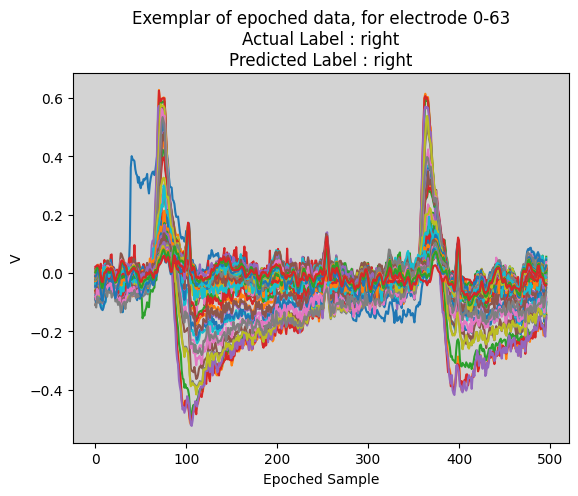

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/EEGClassificationModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint

Predicting: |          | 0/? [00:00<?, ?it/s]





Imagining left hand movement!
Ground-truth: left!


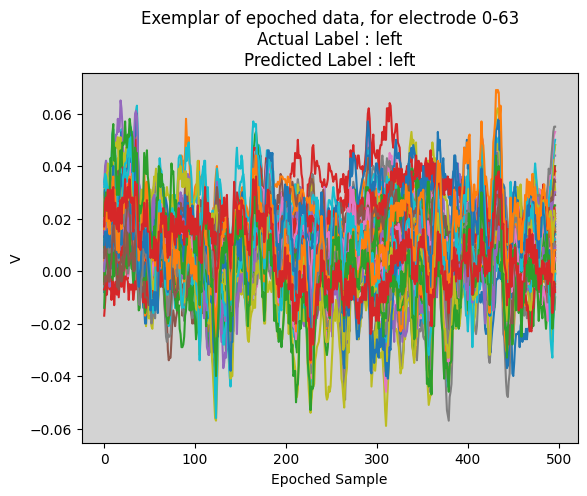

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/EEGClassificationModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint

Predicting: |          | 0/? [00:00<?, ?it/s]





Imagining left hand movement!
Ground-truth: left!


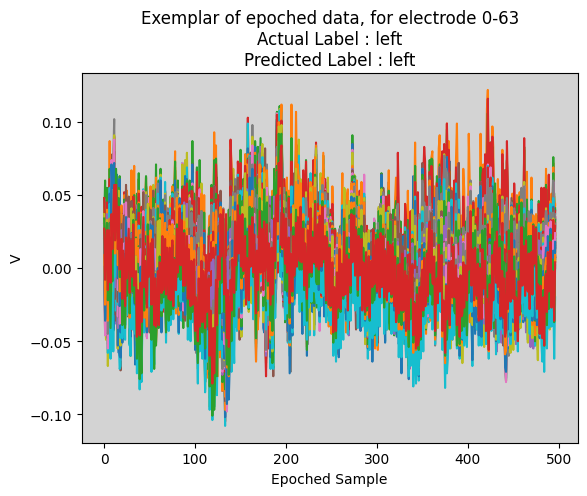

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/EEGClassificationModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint

Predicting: |          | 0/? [00:00<?, ?it/s]





Imagining right hand movement!
Ground-truth: right!


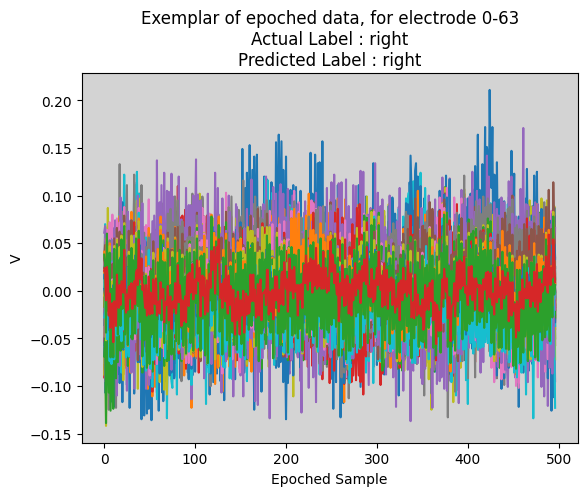

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/EEGClassificationModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint

Predicting: |          | 0/? [00:00<?, ?it/s]





Imagining right hand movement!
Ground-truth: right!


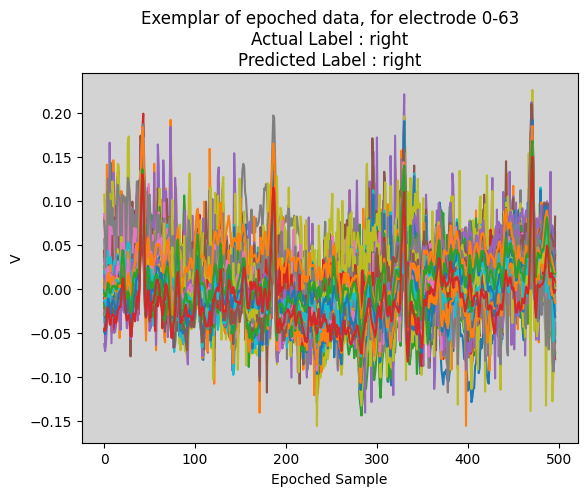

<Figure size 640x480 with 0 Axes>

In [48]:
for _ in range(5):
    N_SAMPLE = X.shape[0]
    sample_idx = random.randint(0, N_SAMPLE - 1)
    sample = X[sample_idx]

    trainer = Trainer()
    prediction = trainer.predict(
        model=model,
        dataloaders=data.DataLoader(
            dataset=EEGDataset.inference_dataset(X[sample_idx]),
            batch_size=1,
            shuffle=False,
        ),
        ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),
    )[0]

    PREDICTED = CLASSES[int(torch.sigmoid(prediction) > 0.5)]
    ACTUAL = CLASSES[y[sample_idx]]
    print("\n\n\n")
    print(f"Imagining {PREDICTED} hand movement!")
    print(f"Ground-truth: {ACTUAL}!")

    plt.plot(sample.T)
    plt.title(
        f"Exemplar of epoched data, for electrode 0-63\nActual Label : {ACTUAL}\nPredicted Label : {PREDICTED}"
    )
    plt.ylabel("V")
    plt.xlabel("Epoched Sample")
    plt.show()
    plt.clf()

    print("\n\n\n")
